<a href="https://colab.research.google.com/github/AatishKumar649/Minor-Project/blob/main/Minor_Project_Tumor_Growth_and_shrink.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torch torchdiffeq matplotlib pandas scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

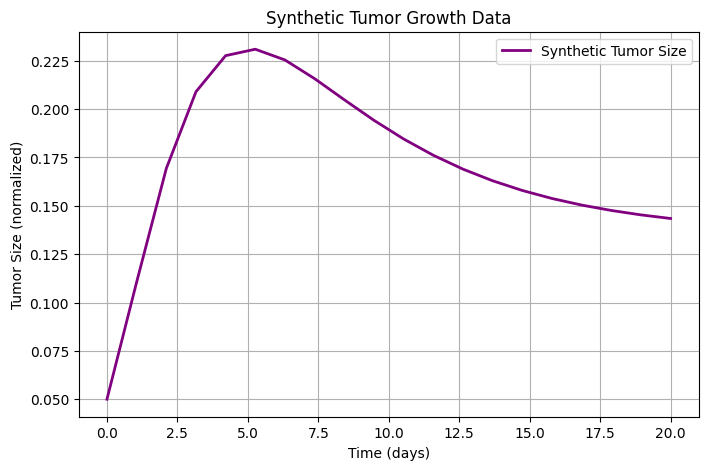

In [2]:
# Install torchdiffeq if not already installed
!pip install -q torchdiffeq

# Imports
import torch
import torch.nn.functional as F
from torchdiffeq import odeint
import numpy as np
import matplotlib.pyplot as plt

# ============================
# 1. Generate Synthetic Data for Tumor Growth Model
# ============================

# Time settings
N_days = 20
T0 = 0.05  # Initial tumor size (normalized)
t = torch.linspace(0., float(N_days), N_days)

# True parameters [r, K, c]
params = torch.tensor([0.5, 1.0, 1.0])

# Tumor growth function with chemotherapy effect
def tumor_growth_chemo(t, T, p):
    T = torch.clamp(T, min=0)
    r, K, c = torch.abs(p)
    chemo_effect = torch.sigmoid(t / 5)
    dTdt = r * T * torch.log(K / T) - c * chemo_effect * T
    return dTdt

# Wrapper for odeint
def tumor_ode_func(t, T):
    return tumor_growth_chemo(t, T, params)

# Initial condition
u0 = torch.tensor([T0])

# Solve ODE
true_sol = odeint(tumor_ode_func, u0, t).squeeze().detach().numpy()

# ============================
# 2. Plot the Results
# ============================

plt.figure(figsize=(8, 5))
plt.plot(t.numpy(), true_sol, label='Synthetic Tumor Size', color='purple', linewidth=2)
plt.xlabel("Time (days)")
plt.ylabel("Tumor Size (normalized)")
plt.title("Synthetic Tumor Growth Data")
plt.legend()
plt.grid(True)
plt.show()


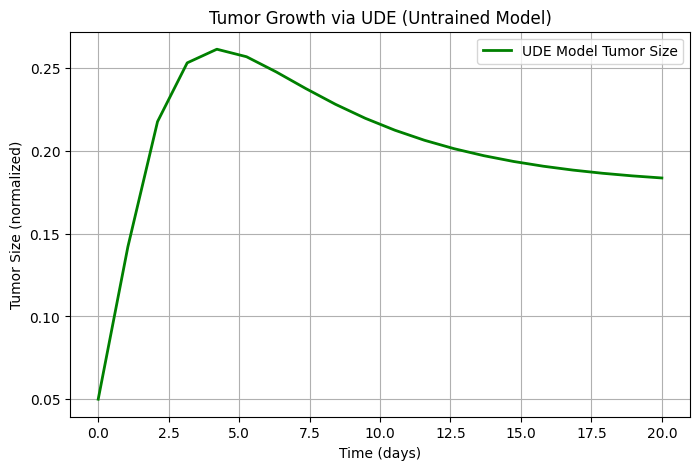

In [3]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchdiffeq import odeint

# ============================
# 2. UDE Model for Tumor Growth
# ============================

# Custom softplus to match Julia's behavior
def my_softplus(x):
    return torch.log1p(torch.exp(x))

# Neural networks for r(T) and K(T)
class NetR(nn.Module):
    def __init__(self):
        super(NetR, self).__init__()
        self.fc1 = nn.Linear(1, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class NetK(nn.Module):
    def __init__(self):
        super(NetK, self).__init__()
        self.fc1 = nn.Linear(1, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Instantiate models
NN_r = NetR()
NN_K = NetK()

# Fixed value for c (from p0[2])
c_fixed = torch.tensor(1.0)

# UDE model using NN_r and NN_K
class TumorUDE(nn.Module):
    def __init__(self, NN_r, NN_K):
        super(TumorUDE, self).__init__()
        self.NN_r = NN_r
        self.NN_K = NN_K

    def forward(self, t, T):
        T = torch.clamp(T, min=0.0)
        T_input = T.view(-1, 1)

        r_out = self.NN_r(T_input)
        K_out = self.NN_K(T_input)

        r = torch.clamp(my_softplus(r_out.squeeze()), 1e-4, 1.0)
        K = torch.clamp(my_softplus(K_out.squeeze()), 0.01, 1.0)

        chemo = torch.sigmoid(t / 5.0)
        dTdt = r * T * torch.log(K / T) - c_fixed * chemo * T
        return dTdt

# Create the ODE function module
ude_model = TumorUDE(NN_r, NN_K)

# Initial condition and time vector
u0 = torch.tensor([T0])
t = torch.linspace(0., float(N_days), N_days)

# Solve the ODE with initial random weights
ude_sol = odeint(ude_model, u0, t).squeeze().detach().numpy()

# ============================
# Plot the UDE model output
# ============================

plt.figure(figsize=(8, 5))
plt.plot(t.numpy(), ude_sol, label='UDE Model Tumor Size', color='green', linewidth=2)
plt.xlabel("Time (days)")
plt.ylabel("Tumor Size (normalized)")
plt.title("Tumor Growth via UDE (Untrained Model)")
plt.legend()
plt.grid(True)
plt.show()


In [4]:
# ============================
# 3. Loss Function
# ============================

# Assume true_sol is already computed from previous synthetic model
true_sol_tensor = torch.tensor(true_sol.squeeze(), dtype=torch.float32)

# Define the loss function
def loss_function():
    try:
        pred_sol = odeint(ude_model, u0, t).squeeze()
    except Exception as e:
        print(f"ODE solve failed: {e}")
        return torch.tensor(float('inf'))

    # Check for NaNs or shape mismatch
    if torch.isnan(pred_sol).any() or pred_sol.shape[0] != true_sol_tensor.shape[0]:
        return torch.tensor(float('inf'))

    return torch.sum((pred_sol - true_sol_tensor) ** 2)


In [5]:
# ============================
# 4. Training with LBFGS
# ============================

# Ensure model parameters are set to require gradients
for param in ude_model.parameters():
    param.requires_grad = True

# Define optimizer (LBFGS from PyTorch)
optimizer = torch.optim.LBFGS(ude_model.parameters(), max_iter=50, history_size=10, line_search_fn='strong_wolfe')

# Define closure required by LBFGS
def closure():
    optimizer.zero_grad()
    loss = loss_function()
    loss.backward()
    return loss

# Perform optimization
optimizer.step(closure)

# Final loss
final_loss = loss_function().item()
print(f"Training completed. Final loss: {final_loss:.6f}")


Training completed. Final loss: 0.000000


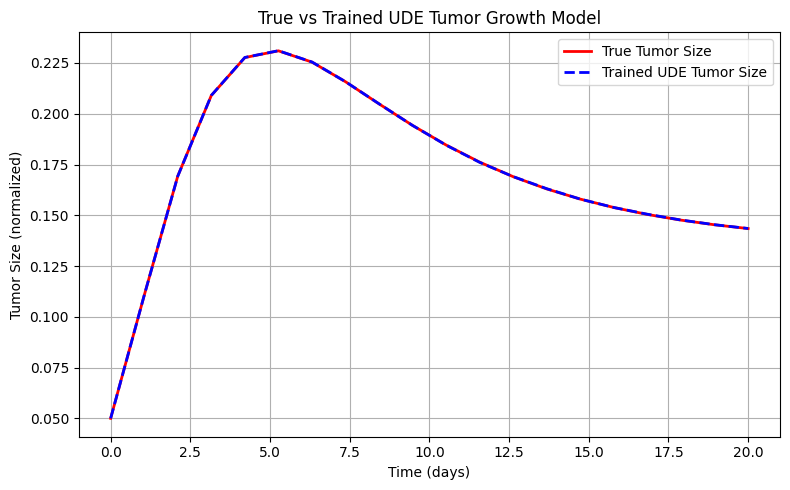

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp # Import solve_ivp
import torch # Import torch as it's needed for the ude_model call

# Define the time span for solve_ivp
tspan = [t.min().item(), t.max().item()]

# Define the ODE right-hand side function for solve_ivp
# solve_ivp expects the function signature fun(t, y)
def ode_rhs(t, y, model):
    # Convert numpy array y to torch tensor
    y_tensor = torch.tensor(y, dtype=torch.float32)
    # Convert numpy scalar t to torch tensor
    t_tensor = torch.tensor(t, dtype=torch.float32)

    # Call the UDE model
    # The model expects time and state as input and returns the derivative
    # The output of the model is a tensor, which solve_ivp expects as a numpy array
    with torch.no_grad(): # Ensure no gradients are computed during evaluation
        # The model expects a tensor of shape [batch_size, num_components] or [num_components]
        # If y is a scalar (e.g., from solve_ivp's internal steps), unsqueeze it
        if y_tensor.dim() == 0:
             y_tensor = y_tensor.unsqueeze(0)
        # If y is 1D (e.g., initial y0), ensure it's treated as a batch of size 1
        elif y_tensor.dim() == 1 and y_tensor.shape[0] == 1:
            pass # Already in correct shape for a single component system
        else:
             # For multi-component systems, handle accordingly. Assuming single component here.
             pass


        dTdt = model(t_tensor, y_tensor)

    # The model's output is dT/dt for each component in the batch.
    # solve_ivp expects a 1D array for the derivatives corresponding to the 1D y input.
    # Squeeze the output to remove the batch dimension if it exists (should be 1).
    return dTdt.squeeze().numpy() # Convert the result back to a numpy array


# Solve the ODE using the trained model
# The initial condition u0 should be converted to numpy if it's a torch tensor
# Remove .squeeze() to keep it 1-dimensional
y0_np = u0.detach().numpy()

trained_sol = solve_ivp(
    fun=lambda t, y: ode_rhs(t, y, ude_model),
    t_span=tspan,
    y0=y0_np, # Use the numpy initial condition
    t_eval=t.numpy(), # Use the numpy time points
    method='RK45'
)

# Convert solutions to NumPy arrays
# Ensure true_sol is a numpy array and extract the relevant part if needed
# Based on the previous code, true_sol is already a numpy array of shape (N_days,)
true_sol_np = true_sol # shape: (N_days,)

# Extract tumor size from ODE solution (solve_ivp returns y as a 2D array)
# trained_sol.y is shape (n_components, n_times), we need the first component
trained_sol_np = trained_sol.y[0]

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(t.numpy(), true_sol_np, label="True Tumor Size", linewidth=2, color="red") # Plot against numpy time points
plt.plot(t.numpy(), trained_sol_np, label="Trained UDE Tumor Size", linewidth=2, linestyle="--", color="blue") # Plot against numpy time points
plt.xlabel("Time (days)")
plt.ylabel("Tumor Size (normalized)")
plt.title("True vs Trained UDE Tumor Growth Model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

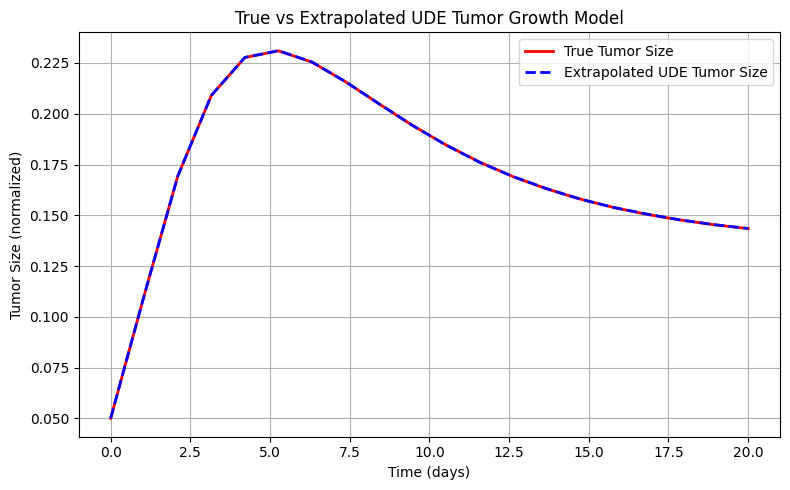

In [10]:
# ============================
# 6. Extrapolation
# ============================

# New extrapolation duration
N_days2 = 20
tspan2 = (0.0, float(N_days2))
t2 = np.linspace(tspan2[0], tspan2[1], N_days2)

# Solve the UDE with extrapolated time range
trained_sol2 = solve_ivp(
    fun=lambda t, y: ode_rhs(t, y, ude_model),
    t_span=tspan2,
    y0=u0,
    t_eval=t2,
    method='RK45'
)

# Plot original and extrapolated prediction
plt.figure(figsize=(8, 5))
plt.plot(t, true_sol, label="True Tumor Size", linewidth=2, color="red")
plt.plot(t2, trained_sol2.y[0], label="Extrapolated UDE Tumor Size", linewidth=2, linestyle="--", color="blue")
plt.xlabel("Time (days)")
plt.ylabel("Tumor Size (normalized)")
plt.title("True vs Extrapolated UDE Tumor Growth Model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# **Melanoma-tumor-size-prediction**

**Import Required Libraries**

In [11]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

**Load CSV File as Pandas Dataframe¶**

In [12]:
df = pd.read_csv('..//content/train.csv')
df.head()

,mass_npea,size_npear,malign_ratio,damage_size,exposed_area,std_dev_malign,err_malign,malign_penalty,damage_ratio,tumor_size
0,6930.90,2919.02,0.42116,51.8298,9.888294e+05,109.487,2758.76,72,39.3620,14.103
1,15635.70,4879.36,0.31206,223.5500,2.058426e+06,248.881,5952.53,240,22.0253,2.648
2,10376.20,2613.88,0.25191,127.3370,1.434676e+06,160.093,4635.26,73,29.9963,1.688
3,13093.80,4510.06,0.34444,155.4400,1.812195e+06,173.015,5273.87,32,28.1354,3.796
4,7545.21,2882.36,0.38201,85.1237,1.043918e+06,124.414,3263.35,57,35.0200,18.023


**Split the Dataframe into Feature and Target Vectors¶**

In [13]:
X = df.drop(columns=['tumor_size'])
X.head()

,mass_npea,size_npear,malign_ratio,damage_size,exposed_area,std_dev_malign,err_malign,malign_penalty,damage_ratio
0,6930.90,2919.02,0.42116,51.8298,9.888294e+05,109.487,2758.76,72,39.3620
1,15635.70,4879.36,0.31206,223.5500,2.058426e+06,248.881,5952.53,240,22.0253
2,10376.20,2613.88,0.25191,127.3370,1.434676e+06,160.093,4635.26,73,29.9963
3,13093.80,4510.06,0.34444,155.4400,1.812195e+06,173.015,5273.87,32,28.1354
4,7545.21,2882.36,0.38201,85.1237,1.043918e+06,124.414,3263.35,57,35.0200


Tumor Size column is dropped and all other columns are saved into a Pandas Dataframe named X. This Dataframe goes as an input to the model during training process.

In [14]:
y = df.loc[:,['tumor_size']]
y.head()

,tumor_size
0,14.103
1,2.648
2,1.688
3,3.796
4,18.023


Here only Tumor Size column is stored into Dataframe named y. This Dataframe is compared with the output predicted by the model during training.

**Split the Data into Training and Validation Sets**

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.25,shuffle=True)

The data is usually divided into 3 parts namely : Train Set, Validation Set and Test Set . Sometimes you also often see people splitting the data into 2 which is Training Set and Test Set. The Training Set is used to train the model to understand about the particular problem. Model does not process Validation or Test Set during Training. After Training, the model is processed on Validation Set. This is done to know whether how well the model has learned on the given set of problem as the model is not trained on these new datas in Validation and Test Set. So error from Validation and Test Sets are considered as actual accuracy of the model i.e. how well the model will perform in the real world.

In [16]:
X_train.head()

,mass_npea,size_npear,malign_ratio,damage_size,exposed_area,std_dev_malign,err_malign,malign_penalty,damage_ratio
5166,10378.60,3566.66,0.34365,121.5500,1.409001e+06,168.534,3767.82,37,33.3583
161,16263.10,3984.43,0.24499,177.6600,2.290201e+06,244.571,5071.24,98,25.9692
4377,7667.55,2320.68,0.30266,72.0221,1.062808e+06,102.434,3175.03,25,38.1239
2494,10775.90,3379.38,0.31360,109.0180,1.535782e+06,165.746,3908.88,22,34.7310
689,7455.28,2201.05,0.29523,75.7381,1.006898e+06,100.175,3090.00,121,35.1777


In [17]:
y_train.head()

,tumor_size
5166,4.288
161,4.688
4377,7.485
2494,6.856
689,14.917


# **Creating a Deep Learning Model using Tensorflow Framework**

In [18]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Input(shape=(9,)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(18,activation='relu'))
model.add(tf.keras.layers.Dense(36,activation='relu'))
model.add(tf.keras.layers.Dense(72,activation='relu'))
model.add(tf.keras.layers.Dense(144,activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.Dense(32,activation='relu'))
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dense(8,activation='relu'))
model.add(tf.keras.layers.Dense(4,activation='relu'))
model.add(tf.keras.layers.Dense(2,activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(1,activation='relu'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 9)              │            36 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 18)             │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │           684 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 72)             │         2,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 144)            │        10,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 144)            │           576 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        18,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2)              │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,269 (172.93 KB)

 Trainable params: 43,959 (171.71 KB)

 Non-trainable params: 310 (1.21 KB)

**Compiling the Model**

In [19]:
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(optimizer=optimizer,loss='mse',metrics=['mae'])

Loss is basically difference between predicted and original value. There are many loss functions which are used for different loss function. Here we use MSE (Mean Squared Error) Loss Function. MSE Loss function from the name we can pretty much identify how this function calculates loss between predicted and original value i.e. it finds mean of squares of the error. Here Error is Difference between Predicted and Original Value. Optimizer is used to minimize the loss function so that the model tries to predict accurately next time.

**Training the model using Fit Method**

In [20]:
model.fit(X_train,y_train,epochs=100,batch_size=32,validation_data=(X_valid,y_valid))

Epoch 1/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 90.4182 - mae: 7.4309 - val_loss: 87.8174 - val_mae: 7.2513
Epoch 2/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 74.5685 - mae: 6.5991 - val_loss: 73.4203 - val_mae: 6.4730
Epoch 3/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 59.7914 - mae: 5.8391 - val_loss: 54.0605 - val_mae: 5.5317
Epoch 4/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 45.5307 - mae: 5.1862 - val_loss: 34.2246 - val_mae: 4.6798
Epoch 5/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 35.3306 - mae: 4.6603 - val_loss: 28.1709 - val_mae: 4.2135
Epoch 6/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 30.3983 - mae: 4.4045 - val_loss: 27.2522 - val_mae: 4.0431
Epoch 7/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 27.0261 - mae: 4.1364 - val_loss: 25.6015 - val_mae: 3.9768
Epoch 8/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 25.0445 - mae: 4.0016 - val_loss: 54.7267 - val_mae: 5.2886
Epoch 9/100
215/215 ━━━━━━━━━━━━

**Predictions on Unknown Data to Check the Actual Loss**

In [21]:
test_df = pd.read_csv('..//content/test.csv')
test_df.head()

,mass_npea,size_npear,malign_ratio,damage_size,exposed_area,std_dev_malign,err_malign,malign_penalty,damage_ratio
0,4946.44,914.06,0.18479,54.5566,6.628345e+05,67.0525,2301.76,22,41.9554
1,5613.85,1629.12,0.29019,51.5524,7.842271e+05,80.1986,3235.00,48,40.7410
2,12421.10,3062.41,0.24654,154.1560,1.763575e+06,186.8590,4684.63,63,29.4778
3,6830.77,2457.66,0.35979,56.8995,9.296623e+05,92.7361,3211.93,42,38.5027
4,33407.80,12353.60,0.36978,219.0740,4.595871e+06,493.3370,13389.36,187,26.8449


In [22]:
submission_df = pd.read_csv('..//content/sample_submission.csv')
submission_df.head()

,tumor_size
0,3.418762
1,7.348026
2,3.096391
3,10.489805
4,27.416072


In [23]:
model.evaluate(test_df,submission_df)

1144/1144 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.1472 - mae: 2.3187


[9.471113204956055, 2.3120009899139404]

In [24]:
pred = model.predict(test_df)
pred = pd.DataFrame(pred)
pred.head()

1144/1144 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


,0
0,4.491774
1,9.131976
2,2.204897
3,10.097675
4,10.141757


We can clearly see that our model's error on unknown real world data is pretty good (MAE : 2.3) and we can also see how close the model predicted from line 57 and 60. It predicted almost near to the actual value. So this model can be used to predict the Tumor Size by giving Parameters mentioned in line 56.